In [15]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
import modal

### Internal Classes
from testing import Tester
from agents.agents import Agent
from agents.specialist_agent import SpecialListAgent

In [16]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN')

In [17]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [18]:
openai = OpenAI()

In [19]:
with open("test.pkl", "rb") as f: 
    test = pickle.load(f)

In [20]:
DB = "products_vectorstore/"

client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection("product")

In [21]:
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

In [ ]:
test[0].test_prompt()

In [22]:
def description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split("\n\nPrice is $")[0]

In [23]:
def vector(item): 
    return embedding_model.encode([description(item)])

In [24]:
def find_similars(item): 
    results = collection.query(query_embeddings=vector(item))
    similar_docs = results["documents"][0][:]
    prices = [meta["price"] for meta in results["metadatas"][0][:]]
    
    return similar_docs, prices 

In [ ]:
find_similars(test[1])

In [25]:
def make_context(similars, prices): 
    message = "To provide some context, here are some other items that might be similar to the item you need to estimate.\n\n"
    for similar, price in zip(similars, prices): 
        message += f"Potentially related product:\n{similar}\nPrice is ${price:.2f}\n\n"
    
    return message

In [26]:
def messages_for(item, similars, prices): 
    system_message = "You estimate prices of items. Reply only with the price, no explanation."
    user_prompt = make_context(similars, prices)
    user_prompt += "And now the question for you:\n\n"  
    user_prompt += item.test_prompt().replace("to the nearest dollar", "").replace("Price is $", "")
    
    return [
        {"role": "system", "content": system_message}, 
        {"role": "user", "content": user_prompt}, 
        {"role": "assistant", "content": "Price is $"}
    ]

In [ ]:
docs, prices = find_similars(test[2])

In [ ]:
print(test[2])

In [ ]:
print(make_context(docs, prices))

In [ ]:
print(messages_for(test[5], docs, prices)[1]["content"])

In [27]:
def get_price(s): 
    s = s.replace("$", "").replace(",", "")
    match = re.search(r"[-+]?\d*.\d+|\d+", s)
    return float(match.group()) if match else 0

In [28]:
def gpt_5_mini_rag(item): 
    documents, prices = find_similars(item)
    response = openai.chat.completions.create(
        model="gpt-5-mini", 
        messages=messages_for(item, documents, prices), 
        seed=42
    )
    reply = response.choices[0].message.content 
    return get_price(reply)

In [22]:
test[500].price

139.37

In [23]:
gpt_5_mini_rag(test[500]) 

239.99

## Evaluate the GPT 5-mini with RAG system

In [ ]:
Tester.test(gpt_5_mini_rag, test[:250])

## Ensemble Agent 

This Ensemble Agent combines the result of each different model of the 2 (GPT 5 mini with RAG + Fine tuned Llama 3.1 8B model) that are normalized in some certain ratio.

In [30]:
Pricer = modal.Cls.from_name("pricer-service", "Pricer")

In [33]:
speicalist_agent = SpecialistAgent()

In [36]:
def emsamble(item): 
    ### Price gotten from the GPT model
    price1 = gpt_5_mini_rag(item)
    ### Price gotten from the remote function (from the fine tuned llama model)
    price2 = speicalist_agent.price(description(item))

    ### combine the 2 results -- 50/50
    return price1 * 0.5 + price2 * 0.5

1: Guess: $197.47 Truth: $249.99 Error: $52.52 SLE: 0.06 Item: Medicom Batman Hush Black Suit Version B...
2: Guess: $8.00 Truth: $3.99 Error: $4.00 SLE: 0.35 Item: ALTKOL S Hooks for Hanging, 15-Pack S Sh...
3: Guess: $119.50 Truth: $109.99 Error: $9.51 SLE: 0.01 Item: Nady RSM-5 Ribbon Microphone - Unique co...
4: Guess: $8.50 Truth: $6.97 Error: $1.53 SLE: 0.03 Item: PANDAFLY Acrylic Paint Pens for Rock Pai...
5: Guess: $164.50 Truth: $164.99 Error: $0.50 SLE: 0.00 Item: Mistel MD600RGB v3 60% Split Mechanical ...
6: Guess: $58.00 Truth: $204.00 Error: $146.00 SLE: 1.55 Item: SWITCH by Design Studio, Big Giant Plaid...
7: Guess: $184.50 Truth: $168.00 Error: $16.50 SLE: 0.01 Item: Polk Audio - A Pair of DB652 6.5" Coaxia...
8: Guess: $34.49 Truth: $15.00 Error: $19.49 SLE: 0.63 Item: 6 Pack of 2 Inch Acoustic Foam Panels- P...
9: Guess: $449.50 Truth: $378.32 Error: $71.18 SLE: 0.03 Item: Guild Guitars Jumbo Jr Mahogany Acoustic...
10: Guess: $105.00 Truth: $122.55 Error: $17.55 SLE

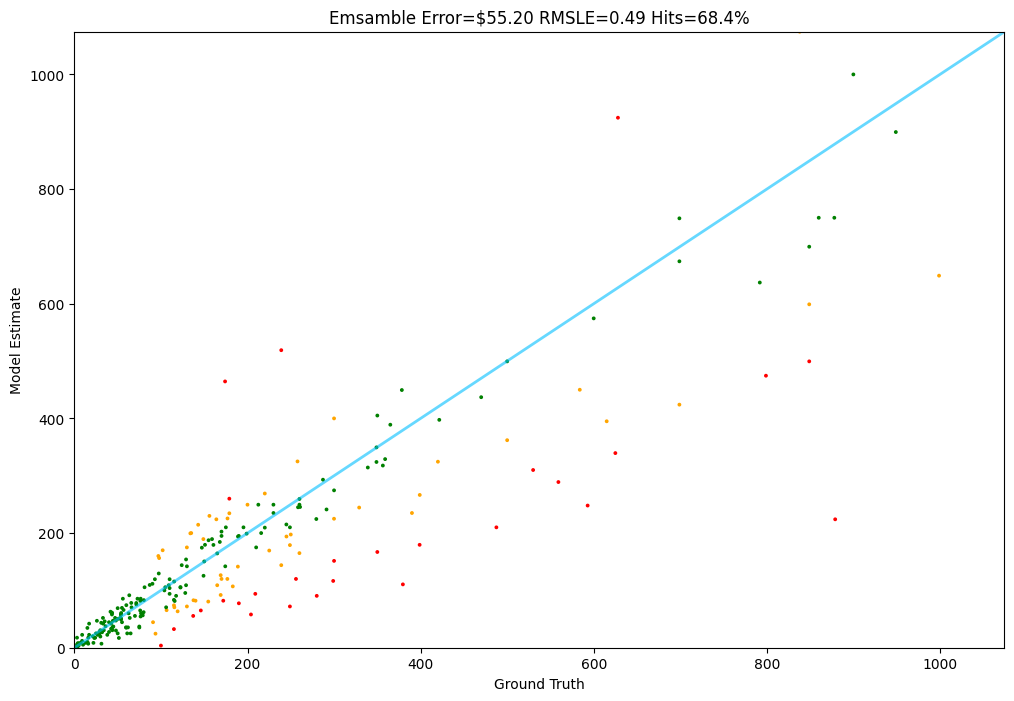

In [37]:
Tester.test(emsamble, test[:250])

In [35]:
test[:2]

[<Medicom Batman Hush Black Suit Version Batman Real Hero Action Figure = $249.99>,
 <ALTKOL S Hooks for Hanging, 15-Pack S Shaped Hook Heavy Duty Hanging Hooks for Pots, Pans, Plants, Bags, Cups, Clothes, 2.4 Inch Metal (Black) = $3.99>]